In [3]:
import urllib
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import math

%matplotlib notebook

cache = {}

def get_data(country):
    url = "https://en.wikipedia.org/w/index.php?title=Template:2019%%E2%%80%%9320_coronavirus_outbreak_data/%s_medical_cases_chart&action=raw" % country
    if url not in cache:
        data = urllib.request.urlopen(url).read()    
        ret = str(data, "utf8")
        cache[url] = ret
    return cache[url]


def postprocess(e, deaths_index, country):
    infos = []
    for l in e.splitlines():
        if "bar stacked" in l.lower() or "bar_stacked" in l.lower():
            info = l.split("|")
            if info[1] in ["----------", "{{nowrap"]:
                continue
            
            if country == "China":
#                print(info)
                case_info = info[4]
                death_info = info[6]
                if case_info == '':
                    case_info = info[2]
                    death_info = info[6]
 
                case_info = case_info.replace(",", "")
                death_info = death_info.replace(",", "")
#                print(case_info, death_info)
                if death_info == "(1367-108)":
                    death_info = str(1367+108)
                    
#                continue
            else:
                case_info = info[2].replace(",", "")
                death_info = info[deaths_index].replace(",", "")

            d = {}
            d["date"] = datetime.datetime.strptime(info[1], '%Y-%m-%d')
            d["cases"] = int(case_info.split("&")[0].replace(",", ""))
            d["deaths"] = int(death_info.replace("{{#expr: ","").split("/")[0].replace(",", ""))
            infos.append(d)
    return infos

def get_data_per_country(country):    
    data = get_data(country)
    
    markers = dict(France=("== Timeline ==", "==="),
                   Italy=("==Statistics==", ""))

    special_deaths_index = dict(South_Korea=5)

    return postprocess(data, special_deaths_index.get(country, 4), country)
        

def plot_date_values(values, offset, multiplier, log_axis, label, key):
    
    start_time = datetime.datetime(2020, 1, 1)
    dates = [(v["date"] - start_time).days  + offset for v in values]
    y = [v[key] * multiplier for v in values]
    if log_axis:
        y = [a for a in y]
    if log_axis:
        plt.yscale("log")

    plt.plot(dates, y, label = label + " %d days" % offset)


<IPython.core.display.Javascript object>


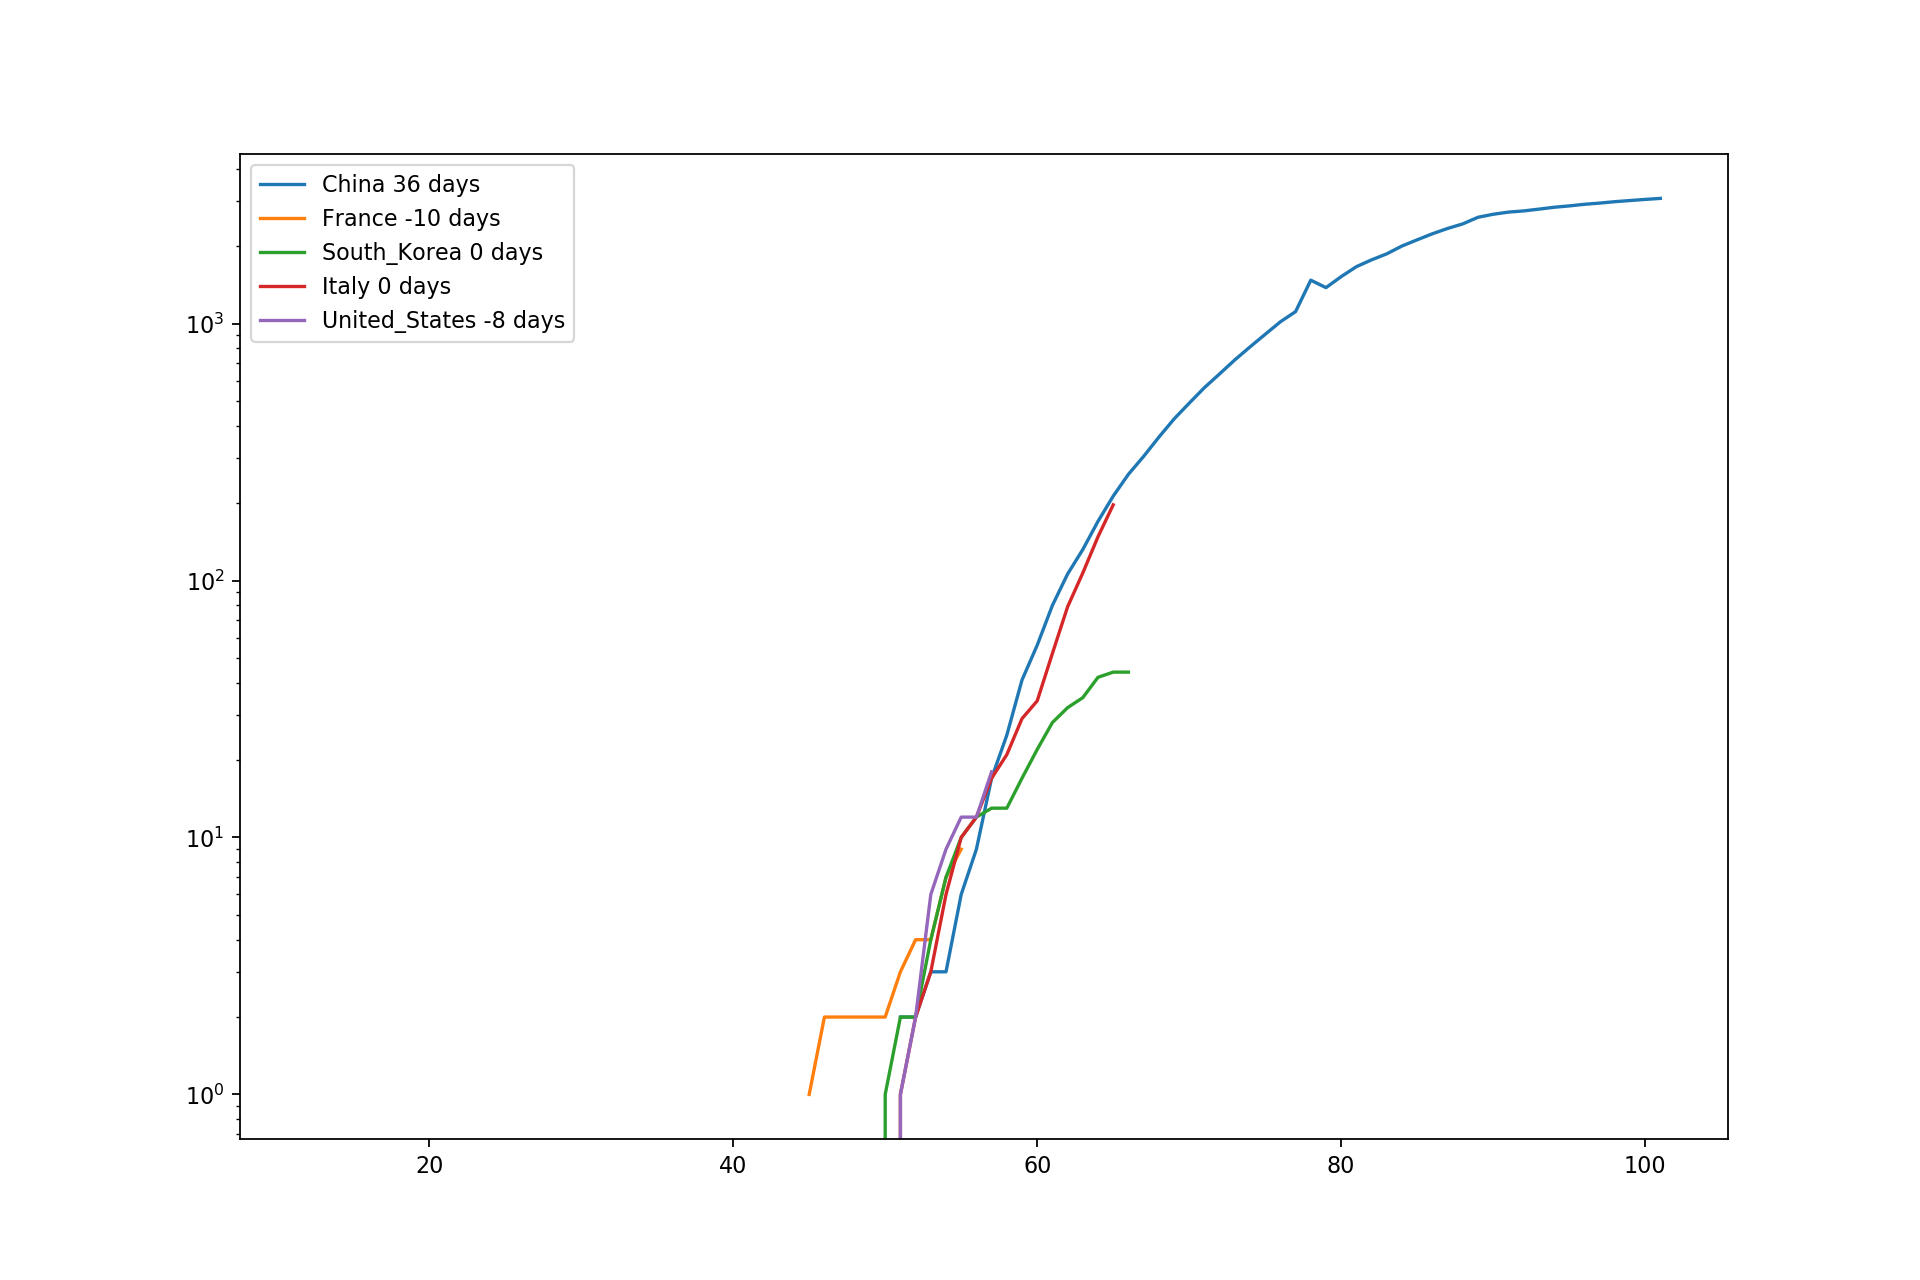

In [13]:
countries = ["China", "France", "South_Korea", "Italy", "United_States"]
#countries = ["United_States"]

fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

log_axis = True
key = "deaths"

offset_by_country = dict(China=36, France=-10, Italy=0, Germany=-9, United_States=-8)
default_offset = 0
multiplier_by_country = dict()
default_multiplier = 1

for country in countries:
    data_for_country = get_data_per_country(country)
#    print(data_for_country)
#    break
    plot_date_values(data_for_country,
                     offset_by_country.get(country, default_offset),
                     multiplier_by_country.get(country, default_multiplier),
                     log_axis, country, key)
    
_ = plt.legend()
